Import Library

In [15]:
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
import cv2
import dlib
import sys
sys.path.append('./Skindetector/')
import skin_detector
import scipy.signal as signal

Load Data

In [16]:
subject_name = 'subject2'
dataset_path = '/pict/'
img_frame_path = './pict/subject1/'

#list every jpg
jpg_list = glob(img_frame_path + '*.jpg')
jpg_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
print(f"First 10 frames: {jpg_list[:10]}")
print(f"Length of jpg_list: {len(jpg_list)}")

First 10 frames: ['./pict/subject1\\frame0.jpg', './pict/subject1\\frame1.jpg', './pict/subject1\\frame2.jpg', './pict/subject1\\frame3.jpg', './pict/subject1\\frame4.jpg', './pict/subject1\\frame5.jpg', './pict/subject1\\frame6.jpg', './pict/subject1\\frame7.jpg', './pict/subject1\\frame8.jpg', './pict/subject1\\frame9.jpg']
Length of jpg_list: 2363


Set global variables

In [17]:
idx_frame_start = 0
idx_frame_end = len(jpg_list)-1
fps = 30
n_segment = 6
left_expand_ratio = 0.25
top_expand_ratio = 0.25

f_cnt = 0
i_cnt = idx_frame_start


In [18]:
detector = dlib.get_frontal_face_detector()

In [19]:
face_left, face_top, face_right, face_bottom = 0, 0, 0, 0
mask = None
n_skinpixels = 0

Loop

Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}, Width:{w}
Height: {h}

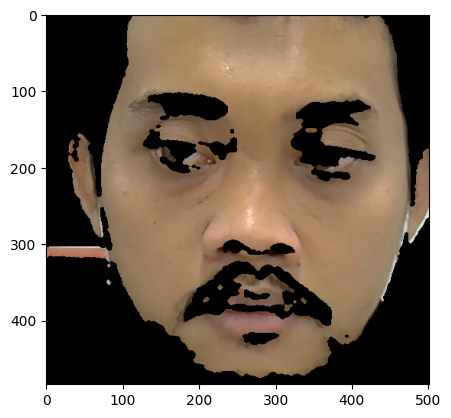

In [20]:

while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end):
    frame = cv2.imread(jpg_list[i_cnt])
    h, w, _ = frame.shape

    plt.imshow(frame)
    #print("Height: {h}, Width:{w}")
    gray_frame =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if f_cnt == 0:
        rect = detector(frame,0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()

        width = abs(right - left)
        height = abs(bottom-right)
        face_left = int(left - (left_expand_ratio/2*width))
        face_top = int (top - (top_expand_ratio/2*height))
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]

    frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_toshow)

    if mask is None:
        mask = skin_detector.process(face)
        n_skinpixels = np.sum(mask)
    #print (f"Mask -> \n{mask}")
    #print (f"Number of skin pixels: {n_skinpixels}")
    
    masked_face = cv2.bitwise_and(face, face, mask=mask)
   
    frame_toshow = cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_toshow)

   #count the mean of every channel
    mean_r = np.sum(masked_face[:,:,2]) / n_skinpixels
    mean_g = np.sum(masked_face[:,:,1]) / n_skinpixels
    mean_b = np.sum(masked_face[:,:,0]) / n_skinpixels


    if f_cnt == 0:
        mean_rgb = np.array([mean_r,mean_g,mean_b])
    else:
        mean_rgb = np.vstack((mean_rgb, np.array([mean_r,mean_g,mean_b])))

    f_cnt +=1
    i_cnt +=1

#break

Check signal mean_rgb

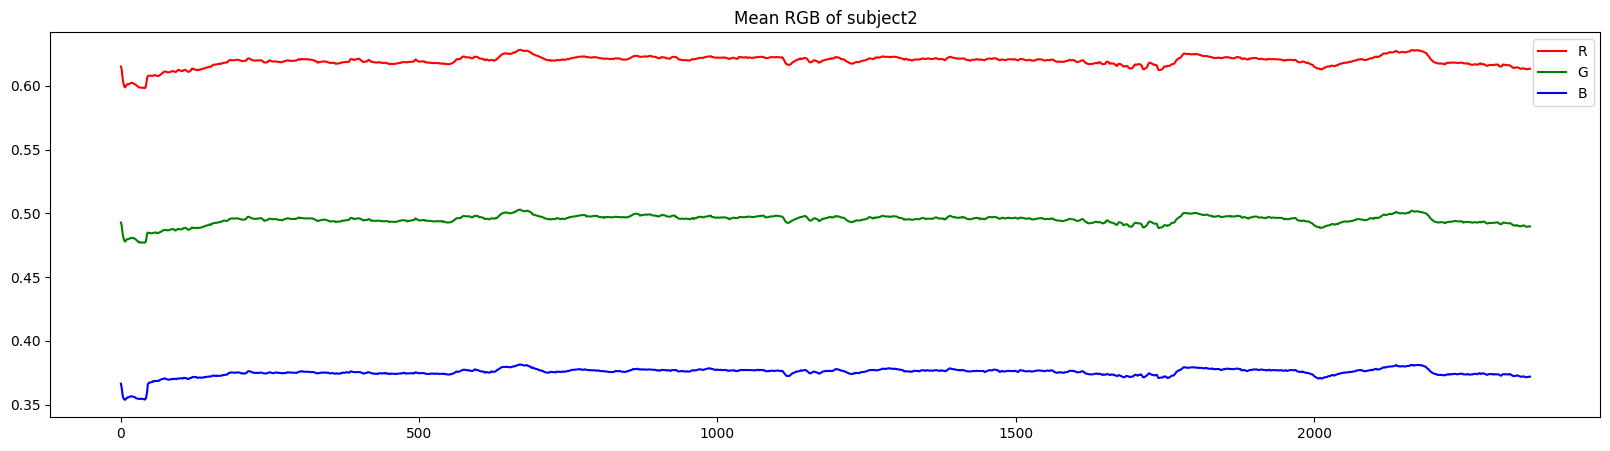

In [21]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb[:,0], label='R', color='red')
plt.plot(mean_rgb[:,1], label='G', color='green')
plt.plot(mean_rgb[:,2], label='B', color='blue')
plt.legend()
plt.title(f"Mean RGB of {subject_name}")
plt.show()

POS

In [22]:
l = int(fps*1.6)
print(f"Window Length:{1}")
rPPG_signals = np.zeros(mean_rgb.shape[0])
print(f"rPPG_signals shape: {rPPG_signals.shape}")

Window Length:1
rPPG_signals shape: (2363,)


POS Calculation

In [23]:
for t in range(0, mean_rgb.shape[0]-1):

    C = mean_rgb[t:t+l-1,:].T

    mean_color = np.mean(C, axis=1)
    diag_mean_color = np.diag(mean_color)
    diag_mean_color_inv = np.linalg.inv(diag_mean_color)

    Cn = np.matmul(diag_mean_color_inv, C)

    projection_matrix = np.array([[0, 1, -1],[-2, 1, 1]])
    S = np.matmul(projection_matrix, Cn)
    #print(f"shape of S:{S.shape}")

    std = np.array([1, np.std(S[0,:])/np.std(S[1,:])])

    P =np.matmul(std, S)

    #plt.figure(figsize=(20,5))
    
    #plt.plot(P)

    rPPG_signals[t:t+l-1]=rPPG_signals[t:t+l-1]+(P-np.mean(P))/np.std(P)
    
    #break



                                        

Shape of rPPG_Signals: (2363,)


<function matplotlib.pyplot.show(close=None, block=None)>

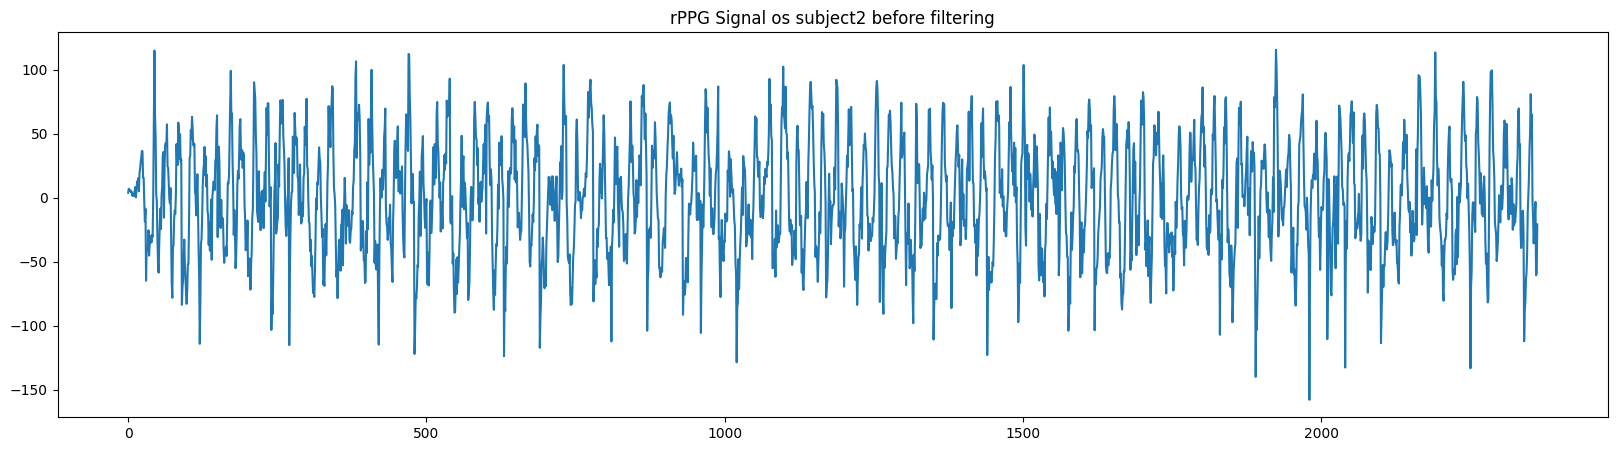

In [24]:
print(f"Shape of rPPG_Signals: {rPPG_signals.shape}")
plt.figure(figsize=(20,5))
plt.plot(rPPG_signals)
plt.title(f"rPPG Signal os {subject_name} before filtering")
plt.show


[  3.80034587   6.98265231   5.71736079 ... -60.66158856 -59.27650187
 -20.86904194]


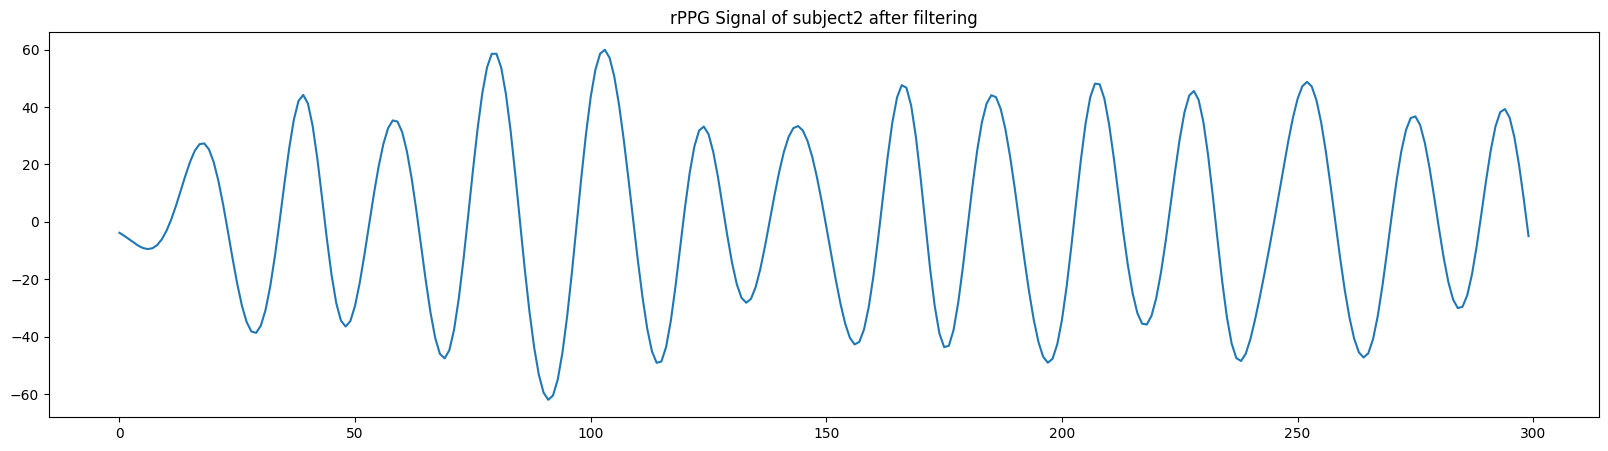

In [25]:

lowcut = 0.8
highcut = 2
b, a = signal.butter(2, [lowcut, highcut], btype='bandpass',fs=fps)
rPPG_filtered = signal.filtfilt(b,a,rPPG_signals)

plt.figure(figsize=(20,5))
plt.plot(rPPG_filtered[5:305])
plt.title(f"rPPG Signal of {subject_name} after filtering")
plt.show
print(rPPG_signals)



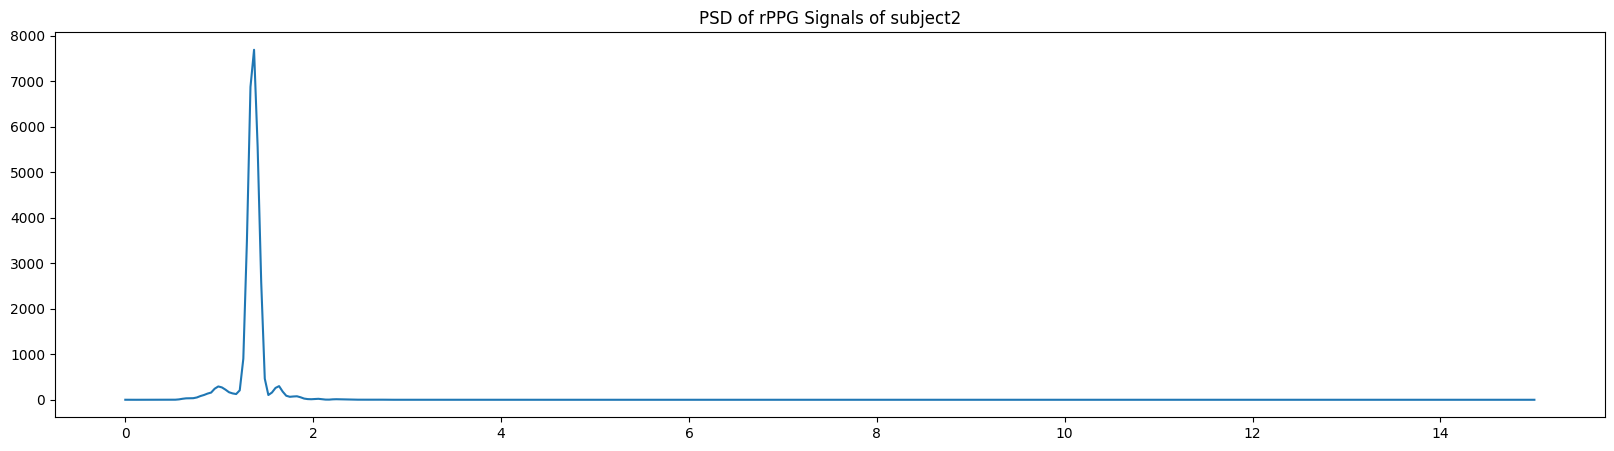

Max frequency of rppg signal subject2 = 1.3705583756345179 Hz
rPPG BPM of Subject subject2= 82.23350253807108 BPM


In [26]:
from scipy.signal import welch
seg_len = (2*rPPG_filtered.shape[0])//n_segment +1

freq_rPPG, psd_rPPG = welch(rPPG_filtered, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_rPPG,psd_rPPG)
plt.title(f"PSD of rPPG Signals of {subject_name}")
plt.show()

max_freq_rPPG = freq_rPPG[np.argmax(psd_rPPG)]
print (f"Max frequency of rppg signal {subject_name} = {max_freq_rPPG} Hz")
rPPG_bpm = max_freq_rPPG *60
print(f"rPPG BPM of Subject {subject_name}= {rPPG_bpm} BPM")


Write to csv

In [27]:
import csv
with open('./txt/subject1.csv','w',encoding='UTF-8', newline='') as f:
    writer =csv.writer(f)
    writer.writerow(rPPG_filtered)